In [1]:
import pandas as pd
import codecs
import numpy as np
import math
import csv
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import recall_score, precision_score # New
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
from keijzer import *
import math

In [2]:
data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2020.csv'
data_source1 = pd.read_csv(data_path)
dat_source1 = pd.DataFrame(data_source1)
#dat_source1 = dat_source1.iloc[:-3,:]

data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2021.csv'
data_source2 = pd.read_csv(data_path)
dat_source2 = pd.DataFrame(data_source2)
dat_source2 = dat_source2.iloc[:8761,:9]

data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2022.csv'
data_source3 = pd.read_csv(data_path)
dat_source3 = pd.DataFrame(data_source3)
dat_source3 = dat_source3.iloc[:8760,:9]

data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2023.csv'
data_source4 = pd.read_csv(data_path)
dat_source4 = pd.DataFrame(data_source4)
dat_source4 = dat_source4.iloc[:8760,:9]

dat_arr1 = np.array(dat_source1)
dat_arr2 = np.array(dat_source2)
dat_arr3 = np.array(dat_source3)
dat_arr4 = np.array(dat_source4)

dat_arr = np.concatenate([dat_arr1, dat_arr2, dat_arr3, dat_arr4],axis=0)
dat_arr.shape # 8784, 8761, 8760, 8760

dat_source = pd.DataFrame(dat_arr, columns=['Time-Date stamp','Date','ERCOT Load','Total Wind Output','Total Wind Installed','Wind Output, % of Load','Wind Output, % of Installed','1-hr MW change','1-hr % change'])
dat_source

,Time-Date stamp,Date,ERCOT Load,Total Wind Output,Total Wind Installed,"Wind Output, % of Load","Wind Output, % of Installed",1-hr MW change,1-hr % change
0,01-01-2020 00:00:00,Jan-01,36823,12335,27040,33.5,45.617,NaN,NaN
1,01-01-2020 01:00:00,Jan-01,36511,13300,27040,36.4,49.187,965.4,7.826
2,01-01-2020 02:00:00,Jan-01,36022,13586,27040,37.7,50.245,286.2,2.152
3,01-01-2020 03:00:00,Jan-01,35790,14107,27040,39.4,52.171,520.9,3.834
4,01-01-2020 04:00:00,Jan-01,35642,14887,27040,41.8,55.055,779.6,5.527
...,...,...,...,...,...,...,...,...,...
35060,12-31-2023 20:00:00,Dec-31,44887,17161,38631,38.23,44.42,2858,19.99
35061,12-31-2023 21:00:00,Dec-31,44013,18301,38631,41.58,47.37,1139,6.64
35062,12-31-2023 22:00:00,Dec-31,43280,18607,38631,42.99,48.17,307,1.67
35063,12-31-2023 23:00:00,Dec-31,42319,17866,38631,42.22,46.25,-741,-3.98


In [3]:
dat = pd.DataFrame()
dat['Timestamp'] = np.array(dat_source['Time-Date stamp'].iloc[1:])
dat['MW % change'] = np.array(dat_source.iloc[1:,3], dtype=float)-np.array(dat_source.iloc[0:-1,3], dtype=float)
dat['MW % change'] = np.divide(np.array(dat['MW % change']),np.array(dat_source.iloc[1:,4]))*100
dat['Total Wind Output'] = np.divide(np.array(dat_source.iloc[1:,3]), np.array(dat_source.iloc[1:,4]))

ramp_ratio = 20
load_ratio = 10
year_arr = np.concatenate([np.ones(8784)*2020, np.ones(8760)*2021, np.ones(8760)*2022, np.ones(8760)*2023])
year_df = pd.DataFrame(year_arr, columns=['Year'], dtype=int)
wind_df = pd.concat([year_df, dat], axis=1)
wind_df[-10:]

,Year,Timestamp,MW % change,Total Wind Output
35054,2023,12-31-2023 15:00:00,0.906008,0.224535
35055,2023,12-31-2023 16:00:00,1.3383,0.237918
35056,2023,12-31-2023 17:00:00,2.27279,0.260646
35057,2023,12-31-2023 18:00:00,2.26243,0.28327
35058,2023,12-31-2023 19:00:00,8.69768,0.370247
35059,2023,12-31-2023 20:00:00,7.3982,0.444229
35060,2023,12-31-2023 21:00:00,2.951,0.473739
35061,2023,12-31-2023 22:00:00,0.79211,0.48166
35062,2023,12-31-2023 23:00:00,-1.91815,0.462478
35063,2023,01-01-2024 00:00:00,-5.16942,0.410784


In [4]:
import sklearn

wind_df = wind_df.reset_index(drop=True)

std_scaler = sklearn.preprocessing.MinMaxScaler()
std_scaler_load = sklearn.preprocessing.MinMaxScaler()
std_scaler_ramp = sklearn.preprocessing.MinMaxScaler()

wind_df[['Total Wind Output']] = std_scaler.fit_transform(wind_df[['Total Wind Output']])
wind_df[['MW % change']] = std_scaler_ramp.fit_transform(wind_df[['MW % change']])
#wind_df[['Wind Change, % of Load', 'Wind Change']] = std_scaler_ramp.fit_transform(wind_df[['Wind Change, % of Load', 'Wind Change']])
wind_df = wind_df.iloc[:-1,:]
wind_df[-10:]

,Year,Timestamp,MW % change,Total Wind Output
35053,2023,12-31-2023 14:00:00,0.475470,0.281695
35054,2023,12-31-2023 15:00:00,0.540013,0.293595
35055,2023,12-31-2023 16:00:00,0.553030,0.311174
35056,2023,12-31-2023 17:00:00,0.581170,0.341026
35057,2023,12-31-2023 18:00:00,0.580858,0.370742
35058,2023,12-31-2023 19:00:00,0.774643,0.484984
35059,2023,12-31-2023 20:00:00,0.735512,0.582157
35060,2023,12-31-2023 21:00:00,0.601593,0.620917
35061,2023,12-31-2023 22:00:00,0.536583,0.631322
35062,2023,12-31-2023 23:00:00,0.454969,0.606127


In [5]:
dat_source1

,time-date stamp,Date,"ERCOT Load, MW","Total Wind Output, MW","Total Wind Installed, MW","Wind Output, % of Load","Wind Output, % of Installed",1-hr MW change,1-hr % change
0,01-01-2020 00:00:00,Jan-01,36823,12335,27040,33.5,45.617,NaN,NaN
1,01-01-2020 01:00:00,Jan-01,36511,13300,27040,36.4,49.187,965.4,7.826
2,01-01-2020 02:00:00,Jan-01,36022,13586,27040,37.7,50.245,286.2,2.152
3,01-01-2020 03:00:00,Jan-01,35790,14107,27040,39.4,52.171,520.9,3.834
4,01-01-2020 04:00:00,Jan-01,35642,14887,27040,41.8,55.055,779.6,5.527
...,...,...,...,...,...,...,...,...,...
8779,12-31-2020 19:00:00,Dec-31,49857,15165,31090,30.4,48.777,788.4,5.484
8780,12-31-2020 20:00:00,Dec-31,48800,15706,31090,32.2,50.517,540.8,3.566
8781,12-31-2020 21:00:00,Dec-31,47848,15079,31090,31.5,48.502,-626.4,-3.989
8782,12-31-2020 22:00:00,Dec-31,46123,14995,31090,32.5,48.231,-84.1,-0.558


In [6]:
data_path = 'C:/Users/smartgrid_AI/Documents/kms/windpower_ramprate/Different forecasting horizon/training_result_df_fh1.csv'
data_source1 = pd.read_csv(data_path)
dat_source1 = pd.DataFrame(data_source1)
dat_source1 = dat_source1.iloc[:,1:]
dat_source1.columns=["Predicted_Value", "Real_Value", "Forecasting_Error", "Initial_Predicted_Value"]

data_path = 'C:/Users/smartgrid_AI/Documents/kms/windpower_ramprate/Different forecasting horizon/training_ramp_result_df_fh1.csv'
data_source2 = pd.read_csv(data_path)
dat_source2 = pd.DataFrame(data_source2)
dat_source2 = dat_source2.iloc[:,1:]
dat_source2.columns=["Ramp_Predicted_Value", "Ramp_Real_Value", "Ramp_Forecasting_Error", "Ramp_Initial_Predicted_Value"]

dat_source = pd.concat([dat_source1, dat_source2], axis=1)
dat_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value
0,0.555163,0.496133,-0.059030,0.539845,0.548483,0.570974,0.022490,0.589907
1,0.542646,0.589203,0.046557,0.550213,0.665944,0.726104,0.060160,0.642168
2,0.631693,0.616454,-0.015239,0.596520,0.587618,0.575205,-0.012413,0.558552
3,0.631930,0.619708,-0.012222,0.628251,0.550581,0.520191,-0.030390,0.546546
4,0.653645,0.589932,-0.063714,0.648182,0.511269,0.444464,-0.066805,0.501161
...,...,...,...,...,...,...,...,...
31501,0.253708,0.253414,-0.000294,0.256929,0.557420,0.527916,-0.029504,0.563698
31502,0.286544,0.272763,-0.013782,0.276661,0.622510,0.557089,-0.065421,0.608928
31503,0.305153,0.323174,0.018020,0.304714,0.626142,0.628303,0.002161,0.609848
31504,0.355719,0.382300,0.026581,0.335575,0.649411,0.648285,-0.001127,0.639267


In [7]:
pred = np.array(dat_source[['Predicted_Value']])
rpred = np.array(dat_source[['Ramp_Predicted_Value']])

real_value = np.array(dat_source[['Predicted_Value']])+np.array(dat_source[['Forecasting_Error']])
real_ramp_value = np.array(dat_source[['Ramp_Predicted_Value']])+np.array(dat_source[['Ramp_Forecasting_Error']])

dat_source['Real_Value'] = real_value
dat_source['Initial_Forecasting_Error'] = real_value-np.array(dat_source[['Initial_Predicted_Value']])
dat_source['Real_Ramp_Value'] = real_ramp_value
dat_source['Ramp_Initial_Forecasting_Error'] = real_value-np.array(dat_source[['Ramp_Initial_Predicted_Value']])
dat_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error
0,0.555163,0.496133,-0.059030,0.539845,0.548483,0.570974,0.022490,0.589907,-0.043712,0.570974,-0.093773
1,0.542646,0.589203,0.046557,0.550213,0.665944,0.726104,0.060160,0.642168,0.038991,0.726104,-0.052965
2,0.631693,0.616454,-0.015239,0.596520,0.587618,0.575205,-0.012413,0.558552,0.019934,0.575205,0.057902
3,0.631930,0.619708,-0.012222,0.628251,0.550581,0.520191,-0.030390,0.546546,-0.008543,0.520191,0.073162
4,0.653645,0.589932,-0.063714,0.648182,0.511269,0.444464,-0.066805,0.501161,-0.058250,0.444464,0.088771
...,...,...,...,...,...,...,...,...,...,...,...
31501,0.253708,0.253414,-0.000294,0.256929,0.557420,0.527916,-0.029504,0.563698,-0.003515,0.527916,-0.310284
31502,0.286544,0.272763,-0.013782,0.276661,0.622510,0.557089,-0.065421,0.608928,-0.003898,0.557089,-0.336165
31503,0.305153,0.323174,0.018020,0.304714,0.626142,0.628303,0.002161,0.609848,0.018460,0.628303,-0.286674
31504,0.355719,0.382300,0.026581,0.335575,0.649411,0.648285,-0.001127,0.639267,0.046725,0.648285,-0.256967


In [8]:
data_path = 'C:/Users/smartgrid_AI/Documents/kms/windpower_ramprate/Different forecasting horizon/test_result_df_fh1.csv'
data_source1 = pd.read_csv(data_path)
dat_source1 = pd.DataFrame(data_source1)
dat_source1 = dat_source1.iloc[:,1:]
dat_source1.columns=["Predicted_Value", "Real_Value", "Forecasting_Error", "Initial_Predicted_Value"]

data_path = 'C:/Users/smartgrid_AI/Documents/kms/windpower_ramprate/Different forecasting horizon/test_ramp_result_df_fh1.csv'
data_source2 = pd.read_csv(data_path)
dat_source2 = pd.DataFrame(data_source2)
dat_source2 = dat_source2.iloc[:,1:]
dat_source2.columns=["Ramp_Predicted_Value", "Ramp_Real_Value", "Ramp_Forecasting_Error", "Ramp_Initial_Predicted_Value"]

test_source = pd.concat([dat_source1, dat_source2], axis=1)
ini_test_source = pd.DataFrame(test_source)

pred = np.array(test_source[['Predicted_Value']])
rpred = np.array(test_source[['Ramp_Predicted_Value']])

real_value = np.array(test_source[['Predicted_Value']])+np.array(test_source[['Forecasting_Error']])
real_ramp_value = np.array(test_source[['Ramp_Predicted_Value']])+np.array(test_source[['Ramp_Forecasting_Error']])

test_source['Real_Value'] = real_value
test_source['Initial_Forecasting_Error'] = real_value-np.array(test_source[['Initial_Predicted_Value']])
test_source['Real_Ramp_Value'] = real_ramp_value
test_source['Ramp_Initial_Forecasting_Error'] = real_value-np.array(test_source[['Ramp_Initial_Predicted_Value']])
test_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error
0,0.631329,0.670123,0.038794,0.604435,0.605291,0.780083,0.174792,0.571514,0.065688,0.780083,0.098609
1,0.617552,0.750445,0.132893,0.590625,0.570113,0.696880,0.126767,0.582499,0.159821,0.696880,0.167946
2,0.725718,0.797475,0.071757,0.678485,0.493175,0.620550,0.127376,0.505756,0.118989,0.620550,0.291719
3,0.686600,0.759475,0.072875,0.668212,0.422408,0.425611,0.003202,0.473355,0.091263,0.425611,0.286120
4,0.726995,0.705090,-0.021905,0.706482,0.468086,0.388045,-0.080041,0.467088,-0.001393,0.388045,0.238001
...,...,...,...,...,...,...,...,...,...,...,...
3473,0.293687,0.293595,-0.000092,0.306307,0.552555,0.540013,-0.012542,0.549945,-0.012711,0.540013,-0.256349
3474,0.294435,0.311174,0.016739,0.306893,0.501416,0.553030,0.051614,0.483705,0.004280,0.553030,-0.172532
3475,0.358716,0.341026,-0.017690,0.345488,0.548501,0.581170,0.032669,0.538511,-0.004462,0.581170,-0.197485
3476,0.368363,0.370742,0.002379,0.363214,0.592809,0.580858,-0.011951,0.561311,0.007528,0.580858,-0.190569


### Plotting Histograms

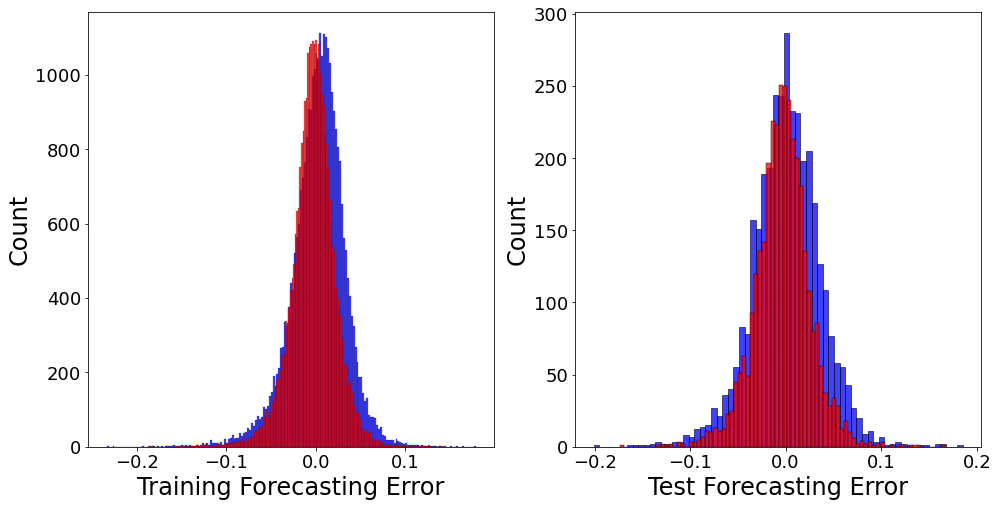

In [9]:
f, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.histplot(data=dat_source, x="Initial_Forecasting_Error", color='blue', ax=ax[0])
sns.histplot(data=dat_source, x="Forecasting_Error", color='red', ax=ax[0])

sns.histplot(data=test_source, x="Initial_Forecasting_Error", color='blue', ax=ax[1])
sns.histplot(data=test_source, x="Forecasting_Error", color='red', ax=ax[1])

ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[0].set_ylabel('Count', fontsize = "24")
a = ax[0].set_xlabel('Training Forecasting Error', fontsize = "24")
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[1].set_ylabel('Count', fontsize = "24")
a = ax[1].set_xlabel('Test Forecasting Error', fontsize = "24")

#f.savefig('GenError_Histogram_FFEL_lead.png', dpi=800, bbox_inches="tight")

In [10]:
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() #

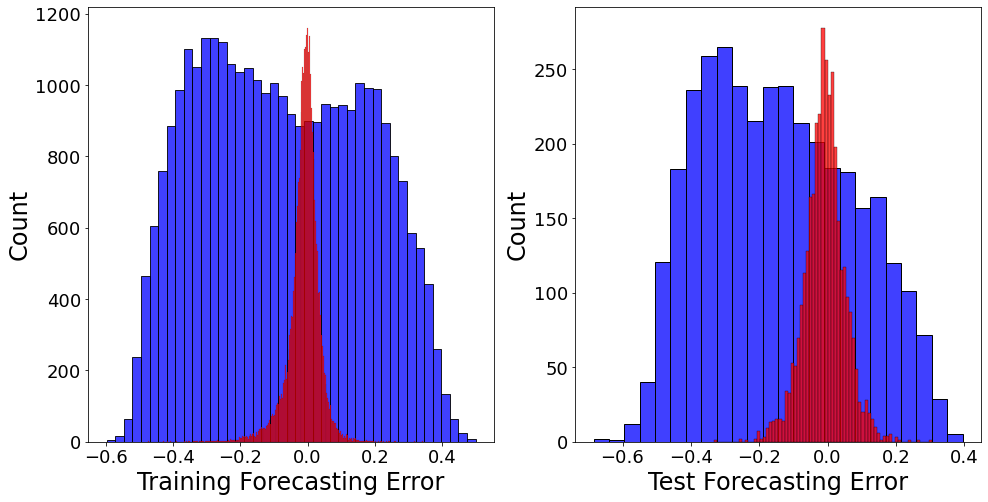

In [11]:
f, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.histplot(data=dat_source, x="Ramp_Initial_Forecasting_Error", color='blue', ax=ax[0])
sns.histplot(data=dat_source, x="Ramp_Forecasting_Error", color='red', ax=ax[0])

sns.histplot(data=test_source, x="Ramp_Initial_Forecasting_Error", color='blue', ax=ax[1])
sns.histplot(data=test_source, x="Ramp_Forecasting_Error", color='red', ax=ax[1])

ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[0].set_ylabel('Count', fontsize = "24")
a = ax[0].set_xlabel('Training Forecasting Error', fontsize = "24")
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[1].set_ylabel('Count', fontsize = "24")
a = ax[1].set_xlabel('Test Forecasting Error', fontsize = "24")

#f.savefig('RampError_Histogram_FFEL_lead.png', dpi=800, bbox_inches="tight")

In [12]:
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() #

## Training/Test Datset Construction

In [9]:
times = np.zeros(dat_source.shape[0], dtype=int)
for i in range(times.shape[0]):
    times[i] = int(i%24)

dat_source['time'] = times
dat_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error,time
0,0.555163,0.496133,-0.059030,0.539845,0.548483,0.570974,0.022490,0.589907,-0.043712,0.570974,-0.093773,0
1,0.542646,0.589203,0.046557,0.550213,0.665944,0.726104,0.060160,0.642168,0.038991,0.726104,-0.052965,1
2,0.631693,0.616454,-0.015239,0.596520,0.587618,0.575205,-0.012413,0.558552,0.019934,0.575205,0.057902,2
3,0.631930,0.619708,-0.012222,0.628251,0.550581,0.520191,-0.030390,0.546546,-0.008543,0.520191,0.073162,3
4,0.653645,0.589932,-0.063714,0.648182,0.511269,0.444464,-0.066805,0.501161,-0.058250,0.444464,0.088771,4
...,...,...,...,...,...,...,...,...,...,...,...,...
31501,0.253708,0.253414,-0.000294,0.256929,0.557420,0.527916,-0.029504,0.563698,-0.003515,0.527916,-0.310284,13
31502,0.286544,0.272763,-0.013782,0.276661,0.622510,0.557089,-0.065421,0.608928,-0.003898,0.557089,-0.336165,14
31503,0.305153,0.323174,0.018020,0.304714,0.626142,0.628303,0.002161,0.609848,0.018460,0.628303,-0.286674,15
31504,0.355719,0.382300,0.026581,0.335575,0.649411,0.648285,-0.001127,0.639267,0.046725,0.648285,-0.256967,16


In [10]:
times = np.zeros(test_source.shape[0], dtype=int)
for i in range(times.shape[0]):
    times[i] = int(i%24)

test_source['time'] = times
test_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error,time
0,0.631329,0.670123,0.038794,0.604435,0.605291,0.780083,0.174792,0.571514,0.065688,0.780083,0.098609,0
1,0.617552,0.750445,0.132893,0.590625,0.570113,0.696880,0.126767,0.582499,0.159821,0.696880,0.167946,1
2,0.725718,0.797475,0.071757,0.678485,0.493175,0.620550,0.127376,0.505756,0.118989,0.620550,0.291719,2
3,0.686600,0.759475,0.072875,0.668212,0.422408,0.425611,0.003202,0.473355,0.091263,0.425611,0.286120,3
4,0.726995,0.705090,-0.021905,0.706482,0.468086,0.388045,-0.080041,0.467088,-0.001393,0.388045,0.238001,4
...,...,...,...,...,...,...,...,...,...,...,...,...
3473,0.293687,0.293595,-0.000092,0.306307,0.552555,0.540013,-0.012542,0.549945,-0.012711,0.540013,-0.256349,17
3474,0.294435,0.311174,0.016739,0.306893,0.501416,0.553030,0.051614,0.483705,0.004280,0.553030,-0.172532,18
3475,0.358716,0.341026,-0.017690,0.345488,0.548501,0.581170,0.032669,0.538511,-0.004462,0.581170,-0.197485,19
3476,0.368363,0.370742,0.002379,0.363214,0.592809,0.580858,-0.011951,0.561311,0.007528,0.580858,-0.190569,20


In [11]:
dat_source

,Predicted_Value,Real_Value,Forecasting_Error,Initial_Predicted_Value,Ramp_Predicted_Value,Ramp_Real_Value,Ramp_Forecasting_Error,Ramp_Initial_Predicted_Value,Initial_Forecasting_Error,Real_Ramp_Value,Ramp_Initial_Forecasting_Error,time
0,0.555163,0.496133,-0.059030,0.539845,0.548483,0.570974,0.022490,0.589907,-0.043712,0.570974,-0.093773,0
1,0.542646,0.589203,0.046557,0.550213,0.665944,0.726104,0.060160,0.642168,0.038991,0.726104,-0.052965,1
2,0.631693,0.616454,-0.015239,0.596520,0.587618,0.575205,-0.012413,0.558552,0.019934,0.575205,0.057902,2
3,0.631930,0.619708,-0.012222,0.628251,0.550581,0.520191,-0.030390,0.546546,-0.008543,0.520191,0.073162,3
4,0.653645,0.589932,-0.063714,0.648182,0.511269,0.444464,-0.066805,0.501161,-0.058250,0.444464,0.088771,4
...,...,...,...,...,...,...,...,...,...,...,...,...
31501,0.253708,0.253414,-0.000294,0.256929,0.557420,0.527916,-0.029504,0.563698,-0.003515,0.527916,-0.310284,13
31502,0.286544,0.272763,-0.013782,0.276661,0.622510,0.557089,-0.065421,0.608928,-0.003898,0.557089,-0.336165,14
31503,0.305153,0.323174,0.018020,0.304714,0.626142,0.628303,0.002161,0.609848,0.018460,0.628303,-0.286674,15
31504,0.355719,0.382300,0.026581,0.335575,0.649411,0.648285,-0.001127,0.639267,0.046725,0.648285,-0.256967,16


In [12]:
pair_ini_source = dat_source[['Initial_Predicted_Value', 'Initial_Forecasting_Error', 'Ramp_Initial_Predicted_Value', 'Ramp_Initial_Forecasting_Error', 'time']]

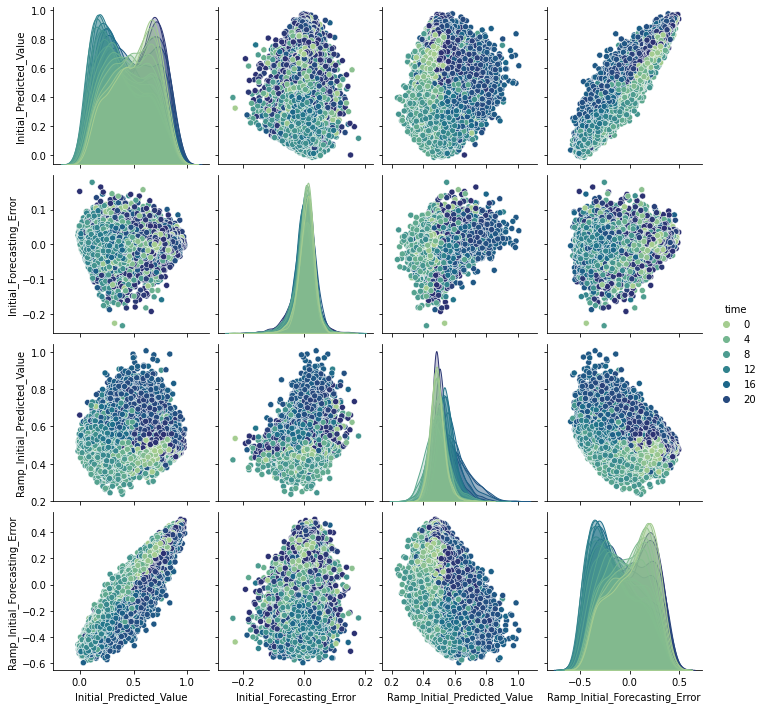

In [17]:
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() #

sns.pairplot(pair_ini_source, palette="crest", hue='time')
#plt.savefig('pairplot_ini_with_time_lead.png', dpi=1000, bbox_inches="tight")

In [18]:
pair_source = dat_source[['Predicted_Value', 'Forecasting_Error', 'Ramp_Predicted_Value', 'Ramp_Forecasting_Error', 'time']]

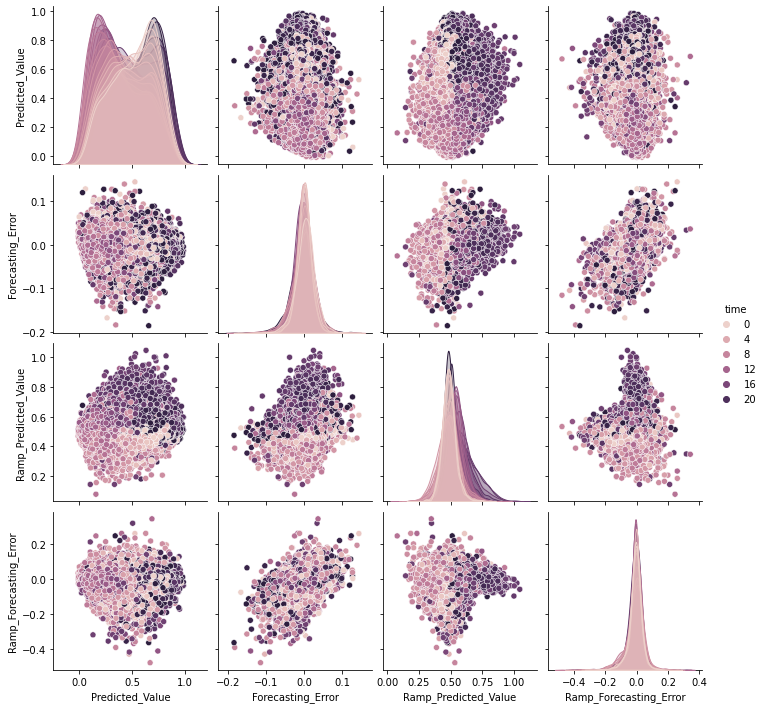

In [19]:
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() #

sns.pairplot(pair_source, hue='time')
#plt.savefig('pairplot_with_time_lead.png', dpi=1000, bbox_inches="tight")

In [13]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.square(y_true - y_pred))

def mae(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(abs(y_true - y_pred))

def maemd(y_true, y_pred):
    return np.mean((abs(y_pred - y_true))*np.square(y_true-np.mean(y_true)))*100

def maems(y_true, y_pred):
    return np.mean((abs(y_pred - y_true))*np.square(y_true))*100

In [14]:
tr_source = pd.DataFrame()
tr_source['Predicted_Value'] = dat_source['Predicted_Value']
tr_source['Real_Value'] = dat_source['Predicted_Value']+dat_source['Forecasting_Error']
tr_source['Ramp_Predicted_Value'] = dat_source['Ramp_Predicted_Value']
tr_source['Ramp_Real_Value'] = dat_source['Ramp_Predicted_Value']+dat_source['Ramp_Forecasting_Error']

times = np.zeros(tr_source.shape[0], dtype=int)
for i in range(times.shape[0]):
    times[i] = int(i%24)

tr_source['time'] = times
normtr_source = np.array(tr_source)
normtr_source

array([[ 0.55516285,  0.49613315,  0.54848331,  0.5709736 ,  0.        ],
       [ 0.54264617,  0.58920304,  0.66594434,  0.72610425,  1.        ],
       [ 0.63169259,  0.61645367,  0.58761829,  0.57520544,  2.        ],
       ...,
       [ 0.30515346,  0.32317352,  0.62614185,  0.62830308, 15.        ],
       [ 0.3557193 ,  0.38229992,  0.64941132,  0.6482846 , 16.        ],
       [ 0.42021394,  0.44595841,  0.6817379 ,  0.65867498, 17.        ]])

In [15]:
tr_source[['Predicted_Value']] = std_scaler.inverse_transform(tr_source[['Predicted_Value']])
tr_source[['Real_Value']] = std_scaler.inverse_transform(tr_source[['Real_Value']])

tr_source[['Ramp_Predicted_Value']] = std_scaler_ramp.inverse_transform(tr_source[['Ramp_Predicted_Value']])
tr_source[['Ramp_Real_Value']] = std_scaler_ramp.inverse_transform(tr_source[['Ramp_Real_Value']])
tr_source

,Predicted_Value,Real_Value,Ramp_Predicted_Value,Ramp_Real_Value,time
0,0.423677,0.378735,1.187307,1.934172,0
1,0.414148,0.449593,5.087990,7.085799,1
2,0.481942,0.470340,2.486914,2.074704,2
3,0.482123,0.472818,1.256973,0.247781,3
4,0.498656,0.450148,-0.048524,-2.267012,4
...,...,...,...,...,...
31501,0.194167,0.193943,1.484082,0.504300,13
31502,0.219166,0.208674,3.645613,1.473086,14
31503,0.233334,0.247054,3.766216,3.837987,15
31504,0.271832,0.292069,4.538956,4.501539,16


In [16]:
trgen_pred = np.array(tr_source['Predicted_Value']).reshape(-1,1)
trgen_real = np.array(tr_source['Real_Value']).reshape(-1,1)
trram_pred = np.array(tr_source['Ramp_Predicted_Value']).reshape(-1,1)
trram_real = np.array(tr_source['Ramp_Real_Value']).reshape(-1,1)

trng_pred = np.array(normtr_source[:,0]).reshape(-1,1)
trnr_pred = np.array(normtr_source[:,2]).reshape(-1,1)

In [17]:
tgram = np.zeros(trgen_pred.shape)

for i in range(tgram.shape[0]):
    for j in range(tgram.shape[1]):
        if (i==0) & (j==0):
            gen0 = trgen_real[0,0]-trram_real[0,0]/100
        elif j==0:
            gen0 = trgen_real[i-1,0]
        else:
            gen0 = trgen_pred[i,j-1]
        
        tgram[i,j] = (trgen_pred[i,j]-gen0)*100

### Reconstruction of Original Dataset

In [18]:
t_source = pd.DataFrame()

In [19]:
t_source['Predicted_Value'] = ini_test_source['Predicted_Value']
t_source['Real_Value'] = ini_test_source['Predicted_Value']+ini_test_source['Forecasting_Error']
t_source['Ramp_Predicted_Value'] = ini_test_source['Ramp_Predicted_Value']
t_source['Ramp_Real_Value'] = ini_test_source['Ramp_Predicted_Value']+ini_test_source['Ramp_Forecasting_Error']

times = np.zeros(ini_test_source.shape[0])
for i in range(times.shape[0]):
    times[i] = int(i%24)

t_source['time'] = times

In [20]:
normt_source = np.array(t_source)
normt_source

array([[ 0.63132918,  0.67012278,  0.60529053,  0.78008267,  0.        ],
       [ 0.61755228,  0.75044544,  0.57011276,  0.69687964,  1.        ],
       [ 0.72571784,  0.79747464,  0.4931747 ,  0.62055025,  2.        ],
       ...,
       [ 0.35871586,  0.34102591,  0.54850119,  0.58117028, 19.        ],
       [ 0.36836344,  0.37074228,  0.59280914,  0.58085847, 20.        ],
       [ 0.43384677,  0.48498374,  0.65861279,  0.77464268, 21.        ]])

In [21]:
t_source[['Predicted_Value']] = std_scaler.inverse_transform(t_source[['Predicted_Value']])
t_source[['Real_Value']] = std_scaler.inverse_transform(t_source[['Real_Value']])

t_source[['Ramp_Predicted_Value']] = std_scaler_ramp.inverse_transform(t_source[['Ramp_Predicted_Value']])
t_source[['Ramp_Real_Value']] = std_scaler_ramp.inverse_transform(t_source[['Ramp_Real_Value']])
t_source

,Predicted_Value,Real_Value,Ramp_Predicted_Value,Ramp_Real_Value,time
0,0.481666,0.511201,3.073779,8.878331,0.0
1,0.471177,0.572354,1.905585,6.115299,1.0
2,0.553528,0.608159,-0.649398,3.580529,2.0
3,0.523746,0.579228,-2.999432,-2.893088,3.0
4,0.554500,0.537822,-1.482551,-4.140567,4.0
...,...,...,...,...,...
3473,0.224605,0.224535,1.322518,0.906008,17.0
3474,0.225174,0.237918,-0.375708,1.338303,18.0
3475,0.274114,0.260646,1.187901,2.272786,19.0
3476,0.281459,0.283270,2.659293,2.262432,20.0


## Combination of Two Forecasting Results

In [22]:
gen_pred = np.array(t_source['Predicted_Value']).reshape(-1,1)
gen_real = np.array(t_source['Real_Value']).reshape(-1,1)
ram_pred = np.array(t_source['Ramp_Predicted_Value']).reshape(-1,1)
ram_real = np.array(t_source['Ramp_Real_Value']).reshape(-1,1)

ng_pred = np.array(normt_source[:,0]).reshape(-1,1)
nr_pred = np.array(normt_source[:,2]).reshape(-1,1)

f_gen = np.zeros(gen_pred.shape)
f_ram = np.zeros(gen_pred.shape)

In [23]:
f_gen = np.zeros(gen_pred.shape)
f_ram = np.zeros(gen_pred.shape)

for i in range(gen_pred.shape[0]):    
    for j in range(gen_pred.shape[1]):
        if (i==0) & (j==0):
            gen0 = gen_real[0,0]-ram_real[0,0]/100
            
        elif j==0:
            gen0 = gen_real[i-1,0]
            
        else:
            gen0 = f_gen[i,j-1]
        
        if ((nr_pred[i,j]<0.2)) | ((nr_pred[i,j]>0.8)):
            rind = 1
        else:
            rind = 0

        if (ng_pred[i,j]>0.8):
            gind = 1
        else:
            gind = 0
            
            
        a = 1/2
        b = 1-a
        
        if gind == 1:
            f_gen[i,j] = gen_pred[i,j]
            f_ram[i,j] = (f_gen[i,j]-gen0)*100
        elif rind == 1:
            f_gen[i,j] = gen0 + ram_pred[i,j]/100
            f_ram[i,j] = ram_pred[i,j]
        else:
            f_gen[i,j] = gen0 + (gen_pred[i,j]-gen0)*a + ram_pred[i,j]/100*b
            f_ram[i,j] = (f_gen[i,j]-gen0)*100

In [24]:
real_gen = np.array(t_source[['Real_Value']])
real_ram = np.array(t_source[['Ramp_Real_Value']])

gen_only = np.array(t_source[['Predicted_Value']])
ram_only = np.array(t_source[['Ramp_Predicted_Value']])

com_gen = f_gen.reshape(-1,1)
com_ram = f_ram.reshape(-1,1)

In [25]:
real_gen = std_scaler.transform(real_gen)
gen_only = std_scaler.transform(gen_only)
com_gen = std_scaler.transform(com_gen)

In [26]:
real_ram = std_scaler_ramp.transform(real_ram)
ram_only = std_scaler_ramp.transform(ram_only)
com_ram = std_scaler_ramp.transform(com_ram)

In [27]:
print('Generation Only Error Test Score > MSE == ', mse(real_gen, gen_only), ' MAE == ', mae(real_gen, gen_only), 'MAPE == ', mape(real_gen, gen_only), ' MAEMS == ', maems(real_gen, gen_only), ' MAEMD == ', maemd(real_gen, gen_only))
print('Combined Generation Error Test Score > MSE == ', mse(real_gen, com_gen), ' MAE == ', mae(real_gen, com_gen), 'MAPE == ', mape(real_gen, com_gen), ' MAEMS == ', maems(real_gen, com_gen), ' MAEMD == ', maemd(real_gen, com_gen))
print('Ramp Rate Only Error Test Score > MSE == ', mse(real_ram, ram_only), ' MAE == ', mae(real_ram, ram_only), 'MAPE == ', mape(real_ram, ram_only), ' MAEMS == ', maems(real_ram, ram_only), ' MAEMD == ', maemd(real_ram, ram_only))
print('Combined Ramp Rate Error Test Score > MSE == ', mse(real_ram, com_ram), ' MAE == ', mae(real_ram, com_ram), 'MAPE == ', mape(real_ram, com_ram), ' MAEMS == ', maems(real_ram, com_ram), ' MAEMD == ', maemd(real_ram, com_ram))

Generation Only Error Test Score > MSE ==  0.0008518177499879865  MAE ==  0.02168118477538205 MAPE ==  8.498436603459671  MAEMS ==  0.438025890540206  MAEMD ==  0.08823475943213886
Combined Generation Error Test Score > MSE ==  0.0005510306456515297  MAE ==  0.01760352255903086 MAPE ==  6.872500077746185  MAEMS ==  0.35387945645077235  MAEMD ==  0.07100779655412262
Ramp Rate Only Error Test Score > MSE ==  0.0035686813472809178  MAE ==  0.04499150950575233 MAPE ==  9.62267393406766  MAEMS ==  1.1967423337216125  MAEMD ==  0.06515405267517589
Combined Ramp Rate Error Test Score > MSE ==  0.002894830807587834  MAE ==  0.04035444298260431 MAPE ==  8.575892762926594  MAEMS ==  1.0761859854280127  MAEMD ==  0.055649083484730924


In [40]:
real_gen2 = real_gen[(real_gen>0.8)]
gen_only2 = gen_only[(real_gen>0.8)]
com_gen2 = com_gen[(real_gen>0.8)]
real_ram2 = real_ram[(real_ram>0.8)|(real_ram<0.2)]
ram_only2 = ram_only[(real_ram>0.8)|(real_ram<0.2)]
com_ram2 = com_ram[(real_ram>0.8)|(real_ram<0.2)]

In [41]:
print('Generation Only Error Test Score > MSE == ', mse(real_gen2, gen_only2), ' MAE == ', mae(real_gen2, gen_only2), 'MAPE == ', mape(real_gen2, gen_only2), ' MAEMS == ', maems(real_gen2, gen_only2), ' MAEMD == ', maemd(real_gen2, gen_only2))
print('Combined Generation Error Test Score > MSE == ', mse(real_gen2, com_gen2), ' MAE == ', mae(real_gen2, com_gen2), 'MAPE == ', mape(real_gen2, com_gen2), ' MAEMS == ', maems(real_gen2, com_gen2), ' MAEMD == ', maemd(real_gen2, com_gen2))
print('Ramp Rate Only Error Test Score > MSE == ', mse(real_ram2, ram_only2), ' MAE == ', mae(real_ram2, ram_only2), 'MAPE == ', mape(real_ram2, ram_only2), ' MAEMS == ', maems(real_ram2, ram_only2), ' MAEMD == ', maemd(real_ram2, ram_only2))
print('Combined Ramp Rate Error Test Score > MSE == ', mse(real_ram2, com_ram2), ' MAE == ', mae(real_ram2, com_ram2), 'MAPE == ', mape(real_ram2, com_ram2), ' MAEMS == ', maems(real_ram2, com_ram2), ' MAEMD == ', maemd(real_ram2, com_ram2))

Generation Only Error Test Score > MSE ==  0.0009734337679629769  MAE ==  0.022916912668291295 MAPE ==  2.790172676038539  MAEMS ==  1.5478134281814737  MAEMD ==  0.0006205946894446717
Combined Generation Error Test Score > MSE ==  0.0005558024166539942  MAE ==  0.018635189842777778 MAPE ==  2.270562469930105  MAEMS ==  1.256872237130012  MAEMD ==  0.0005454964575748825
Ramp Rate Only Error Test Score > MSE ==  0.013831088389035044  MAE ==  0.0898217205666336 MAPE ==  30.179221233037218  MAEMS ==  4.233675289602758  MAEMD ==  1.1410149612002525
Combined Ramp Rate Error Test Score > MSE ==  0.010889514956603598  MAE ==  0.0765593455503826 MAPE ==  26.633534364930224  MAEMS ==  3.5337133335450197  MAEMD ==  1.0243242850608596


In [30]:
final = np.concatenate([com_gen, real_gen, com_ram, real_ram], axis=1)

In [31]:
final = pd.DataFrame(final, columns=['Predicted Generation','Real Generation','Predicted Ramp','Real Ramp'])
final.to_csv('Combined_result_df_fh1.csv')

In [32]:
final

,Predicted Generation,Real Generation,Predicted Ramp,Real Ramp
0,0.612605,0.670123,0.648217,0.780083
1,0.656352,0.750445,0.481159,0.696880
2,0.733817,0.797475,0.474607,0.620550
3,0.722339,0.759475,0.340472,0.425611
4,0.733499,0.705090,0.453176,0.388045
...,...,...,...,...
3473,0.296377,0.293595,0.546389,0.540013
3474,0.291548,0.311174,0.508035,0.553030
3475,0.342746,0.341026,0.585114,0.581170
3476,0.372159,0.370742,0.584107,0.580858


In [33]:
dt1 = pd.DataFrame(np.concatenate([real_gen-gen_only, real_ram-ram_only], axis=1), columns=['er1', 'er2'])
dt2 = pd.DataFrame(np.concatenate([real_gen-com_gen, real_ram-com_ram], axis=1), columns=['er1', 'er2'])

### Comparison of the proposed method and the case when the generation forecasting is only adopted

In [34]:
gentoram = np.zeros(gen_pred.shape)

for i in range(gentoram.shape[0]):
    for j in range(gentoram.shape[1]):
        if j==0:
            if i==0:
                gen0 = gen_real[0,0]-ram_real[0,0]/100
            else:
                gen0 = gen_real[i-1,0]   
        else:
            gen0 = gen_pred[i,j-1]
            
        gentoram[i,j] = (gen_pred[i,j]-gen0)*100
        
gentoram = gentoram.reshape(-1,1)

In [35]:
gentoram = std_scaler_ramp.transform(gentoram)

In [36]:
print('Ramp Rate Only Error Test Score > MSE == ', mse(real_ram, ram_only), ' MAE == ', mae(real_ram, ram_only), 'MAPE == ', mape(real_ram, ram_only), ' MAEMS == ', maems(real_ram, ram_only))
print('Interpreted From Generation Forecasting Test Score > MSE == ', mse(real_ram, gentoram), ' MAE == ', mae(real_ram, gentoram), 'MAPE == ', mape(real_ram, gentoram), ' MAEMS == ', maems(real_ram, gentoram))
print('Combined Ramp Rate Error Test Score > MSE == ', mse(real_ram, com_ram), ' MAE == ', mae(real_ram, com_ram), 'MAPE == ', mape(real_ram, com_ram), ' MAEMS == ', maems(real_ram, com_ram))

Ramp Rate Only Error Test Score > MSE ==  0.0035686813472809178  MAE ==  0.04499150950575233 MAPE ==  9.62267393406766  MAEMS ==  1.1967423337216125
Interpreted From Generation Forecasting Test Score > MSE ==  0.004475179288163416  MAE ==  0.04970400592342793 MAPE ==  10.330120898374812  MAEMS ==  1.3423119191829431
Combined Ramp Rate Error Test Score > MSE ==  0.002894830807587834  MAE ==  0.04035444298260431 MAPE ==  8.575892762926594  MAEMS ==  1.0761859854280127


In [38]:
gentoram2 = gentoram[(real_ram>0.8)|(real_ram<0.2)]

In [39]:
print('Ramp Rate Only Error Test Score > MSE == ', mse(real_ram2, ram_only2), ' MAE == ', mae(real_ram2, ram_only2), 'MAPE == ', mape(real_ram2, ram_only2), ' MAEMS == ', maems(real_ram2, ram_only2))
print('Interpreted From Generation Forecasting Test Score > MSE == ', mse(real_ram2, gentoram2), ' MAE == ', mae(real_ram2, gentoram2), 'MAPE == ', mape(real_ram2, gentoram2), ' MAEMS == ', maems(real_ram2, gentoram2))
print('Combined Ramp Rate Error Test Score > MSE == ', mse(real_ram2, com_ram2), ' MAE == ', mae(real_ram2, com_ram2), 'MAPE == ', mape(real_ram2, com_ram2), ' MAEMS == ', maems(real_ram2, com_ram2))

Ramp Rate Only Error Test Score > MSE ==  0.013831088389035044  MAE ==  0.0898217205666336 MAPE ==  30.179221233037218  MAEMS ==  4.233675289602758
Interpreted From Generation Forecasting Test Score > MSE ==  0.010788940906898994  MAE ==  0.08277487668597285 MAPE ==  25.462950770301934  MAEMS ==  4.142418672072879
Combined Ramp Rate Error Test Score > MSE ==  0.010889514956603598  MAE ==  0.0765593455503826 MAPE ==  26.633534364930224  MAEMS ==  3.5337133335450197
